In [1]:
ASSET = "BTCUSDT"
TARGET = "MA_7"
SAVE_DF = f"./-for_optimization-/{ASSET}_{TARGET}_df.csv"
SAVE_SCALER = f"./-for_optimization-/{ASSET}_{TARGET}_scaler.pkl"
SAVE_MODEL = f"./-for_optimization-/{ASSET}_{TARGET}_model.keras"
SAVE_PREDICTIONS = f"./-for_optimization-/{ASSET}_{TARGET}_predictions.csv"


import optuna
from keras.optimizers import Adam, RMSprop
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import importlib
# from __imports__ import *
import data, LSTM_returns
importlib.reload(data)


c:\Users\IC2594\AppData\Local\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'data' from 'c:\\Users\\IC2594\\crypto\\folder-1\\data\\__init__.py'>

In [2]:
import numpy as np
import pandas as pd
import ta  # pip install ta

def compute_slope(series):
    y = series.values
    x = np.arange(len(y))
    if len(y) == 0:
        return np.nan
    return np.polyfit(x, y, 1)[0]

def add_technical_features(df, look_back=14):
    df = df.copy()  # avoid modifying original

    # Return: Daily log return
    df['Return'] = np.log(df['Close'] / df['Close'].shift(1))

    # Risk: Rolling std dev (volatility)
    df['Risk'] = df['Return'].rolling(window=look_back).std()

    # RSI
    df['RSI'] = ta.momentum.RSIIndicator(close=df['Close'], window=look_back).rsi()

    # ADX
    df['ADX'] = ta.trend.ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=look_back).adx()

    # Momentum
    df['MOM'] = df['Close'] - df['Close'].shift(look_back)

    # High-low spread
    df['HL'] = df['High'] - df['Low']

    # High-open & low-open
    df['HO'] = df['High'] - df['Open']
    df['LO'] = df['Low'] - df['Open']

    # Buy pressure ratio
    df['buy_pressure_ratio'] = df['Taker buy quote asset volume'] / df['Quote asset volume']

    # Trades per volume
    df['trades_per_volume'] = df['Number of trades'] / df['Quote asset volume']

    # Rolling slope
    df['slope'] = df['Close'].rolling(window=look_back).apply(compute_slope, raw=False)

    df['MA_7'] = df['Close'].rolling(window=7).mean()

    df['MA_14'] = df['Close'].rolling(window=14).mean()


    # Drop NaN from lookback window
    df = df.dropna()

    # Drop unnecessary columns
    cols_to_drop = [
        'Open', 'High', 'Low', 'Quote asset volume',
        'Number of trades', 'Taker buy base asset volume',
        'Taker buy quote asset volume', 'F&G'
    ]
    df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

    return df

df = data.load_asset(ASSET, sampling='1d')
df = data.add_fear_and_greed(df)
# Restrict data after 2022
df = add_technical_features(df)
df = df[df.index >= '2022-01-01']
df = df[df.index <= '2025-01-01']
split = len(df[df.index >= '2024-06-01']) / len(df)
df.head()

,Close,Volume,F&G category,Return,Risk,RSI,ADX,MOM,HL,HO,LO,buy_pressure_ratio,trades_per_volume,slope,MA_7,MA_14
Open time,,,,,,,,,,,,,,,,
2022-01-01,47722.65,19604.46325,Extreme Fear,0.032060,0.027996,43.994029,29.926197,888.17,1746.26,1737.70,-8.56,0.507208,0.000774,-90.927165,48077.968571,48548.405714
2022-01-02,47286.18,18340.46040,Fear,-0.009188,0.028115,42.744483,29.728726,604.95,1336.00,267.34,-1068.66,0.499858,0.000819,-188.546000,47579.495714,48591.616429
2022-01-03,46446.10,27662.07710,Fear,-0.017926,0.028524,40.367940,29.918303,-468.06,1874.00,283.82,-1590.18,0.488994,0.000685,-305.147231,46971.590000,48558.183571
2022-01-04,45832.01,35491.41360,Extreme Fear,-0.013310,0.025961,38.675184,30.169434,-3057.87,2057.54,1111.44,-946.10,0.498266,0.000620,-372.102857,46727.057143,48339.764286
2022-01-05,43451.13,51784.11857,Extreme Fear,-0.053346,0.029056,32.912682,31.372611,-5137.03,4570.00,1237.99,-3332.01,0.455508,0.000633,-503.589253,46296.552857,47972.833571


In [3]:
# Hyperparameters (from Optuna)
UNITS_L0 = 160
DROPOUT_L0 = 0.0
LEARNING_RATE = 0.000728
BATCH_SIZE = 32
MAX_EPOCHS = 50

def train_lstm(df, sequence_length=30, test_size=split, target='MA_7'):
    # Prepare data
    features = [
        'Close', 'Volume', 'F&G category', 'Return', 'Risk', 'RSI', 'ADX',
        'MOM', 'HL', 'HO', 'LO', 'buy_pressure_ratio', 'trades_per_volume', 
        'slope', 'MA_7', 'MA_14'
    ]
    num_feats = [f for f in features if f != 'F&G category']
    df_num = df[num_feats]
    df_cat = pd.get_dummies(df['F&G category'], prefix='F_G')
    df_all = pd.concat([df_num, df_cat], axis=1).dropna()
    target_idx = list(df_all.columns).index(target)
    # Move the target column to the last position
    columns = list(df_all.columns)
    columns.append(columns.pop(target_idx))
    df_all = df_all[columns]
    target_idx = len(columns) - 1

    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(df_all)

    # Build sequences
    X, y = zip(*[
        (data_scaled[i-sequence_length:i], data_scaled[i, target_idx])
        for i in range(sequence_length, len(data_scaled))
    ])
    X, y = np.array(X), np.array(y)

    # Train-test split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, shuffle=False)

    # Build and compile model
    model = Sequential([
        Input(shape=(sequence_length, X.shape[2])),
        LSTM(UNITS_L0, dropout=DROPOUT_L0),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='mean_squared_error')

    # Train model
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                        epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, callbacks=[es], verbose=1)

    return model, scaler, history, (X_val, y_val), df_all, data_scaled



In [4]:
def objective(trial):
    global UNITS_L0, DROPOUT_L0, LEARNING_RATE, BATCH_SIZE, MAX_EPOCHS

    # Suggest hyperparameters
    UNITS_L0 = trial.suggest_int("units_l0", 50, 200)
    DROPOUT_L0 = trial.suggest_float("dropout_l0", 0.0, 0.5)
    LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    BATCH_SIZE = trial.suggest_categorical("batch_size", [16, 32, 64])
    MAX_EPOCHS = trial.suggest_int("max_epochs", 10, 100)
    sequence_length = trial.suggest_int("sequence_length", 10, 60)


    # Train the LSTM model
    model, scaler, history, (X_val, y_val), _, _ = train_lstm(
        df,
        sequence_length=sequence_length,
        test_size=split,
        target=TARGET
    )

    # Predict on validation set
    y_pred = model.predict(X_val).flatten()

    # Create a placeholder array with zeros, except for the last column (target)
    dummy = np.zeros((len(y_pred), X_val.shape[2]))
    dummy[:, -1] = y_pred

    # Inverse transform using the entire dummy array
    y_pred_inv = scaler.inverse_transform(dummy)[:, -1]

    # Inverse transform for the actual values
    dummy_y_val = np.zeros((len(y_val), X_val.shape[2]))
    dummy_y_val[:, -1] = y_val
    y_val_inv = scaler.inverse_transform(dummy_y_val)[:, -1]

    # Calculate MSE
    mse = mean_squared_error(y_val_inv, y_pred_inv)

    return mse

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40)

[I 2025-05-09 19:33:39,530] A new study created in memory with name: no-name-4c6627ad-64e8-4e6c-87fe-785308b17123


Epoch 1/59


C:\Users\IC2594\AppData\Local\Temp\ipykernel_1728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0696 - val_loss: 0.0073
Epoch 2/59
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0072 - val_loss: 0.0501
Epoch 3/59
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0055 - val_loss: 0.0283
Epoch 4/59
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0045 - val_loss: 0.0345
Epoch 5/59
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0047 - val_loss: 0.0512
Epoch 6/59
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0051 - val_loss: 0.0365
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[I 2025-05-09 19:33:47,020] Trial 0 finished with value: 54964054.68528533 and parameters: {'units_l0': 174, 'dropout_l0': 0.33191617017358627, 'learning_rate': 0.0025462666840687996, 'batch_size': 32, 'max_epochs': 59, 'sequence_length': 50}. Best is trial 0 with value: 54964054.68528533.


Epoch 1/19


C:\Users\IC2594\AppData\Local\Temp\ipykernel_1728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0784 - val_loss: 0.3566
Epoch 2/19
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0471 - val_loss: 0.2508
Epoch 3/19
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0286 - val_loss: 0.1933
Epoch 4/19
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0217 - val_loss: 0.1385
Epoch 5/19
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0167 - val_loss: 0.1065
Epoch 6/19
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0107 - val_loss: 0.0764
Epoch 7/19
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0075 - val_loss: 0.0570
Epoch 8/19
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0077 - val_loss: 0.0440
Epoch 9/19
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0062 - val_loss: 0.0394
Epoch 10/19
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0046 - val_loss: 0.0302
Epoch 11/19
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0039 - val_loss: 0.0280
Epoch 12/19
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0032 - val_l

[I 2025-05-09 19:34:04,425] Trial 1 finished with value: 134000418.42069864 and parameters: {'units_l0': 163, 'dropout_l0': 0.1360601953393375, 'learning_rate': 1.4632032656959983e-05, 'batch_size': 16, 'max_epochs': 19, 'sequence_length': 28}. Best is trial 0 with value: 54964054.68528533.


Epoch 1/31


C:\Users\IC2594\AppData\Local\Temp\ipykernel_1728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.1122 - val_loss: 0.0341
Epoch 2/31
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0084 - val_loss: 0.0479
Epoch 3/31
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0083 - val_loss: 0.0472
Epoch 4/31
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0071 - val_loss: 0.0385
Epoch 5/31
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0071 - val_loss: 0.0433
Epoch 6/31
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0080 - val_loss: 0.0562
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


[I 2025-05-09 19:34:13,436] Trial 2 finished with value: 255739201.48849085 and parameters: {'units_l0': 90, 'dropout_l0': 0.42070093370189404, 'learning_rate': 0.00895315480862492, 'batch_size': 32, 'max_epochs': 31, 'sequence_length': 50}. Best is trial 0 with value: 54964054.68528533.


Epoch 1/43


C:\Users\IC2594\AppData\Local\Temp\ipykernel_1728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - loss: 0.2186 - val_loss: 0.0971
Epoch 2/43
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0148 - val_loss: 0.0184
Epoch 3/43
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0088 - val_loss: 0.0214
Epoch 4/43
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0079 - val_loss: 0.0484
Epoch 5/43
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0076 - val_loss: 0.0338
Epoch 6/43
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0073 - val_loss: 0.0491
Epoch 7/43
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0064 - val_loss: 0.0507
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


[I 2025-05-09 19:34:28,783] Trial 3 finished with value: 137900958.58750623 and parameters: {'units_l0': 196, 'dropout_l0': 0.3917987798651694, 'learning_rate': 0.002946690269715551, 'batch_size': 64, 'max_epochs': 43, 'sequence_length': 60}. Best is trial 0 with value: 54964054.68528533.


Epoch 1/85


C:\Users\IC2594\AppData\Local\Temp\ipykernel_1728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 0.0575 - val_loss: 0.0180
Epoch 2/85
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0080 - val_loss: 0.0205
Epoch 3/85
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0070 - val_loss: 0.0239
Epoch 4/85
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0058 - val_loss: 0.0260
Epoch 5/85
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0065 - val_loss: 0.0242
Epoch 6/85
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0047 - val_loss: 0.0306
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


[I 2025-05-09 19:34:36,341] Trial 4 finished with value: 134986353.74226233 and parameters: {'units_l0': 70, 'dropout_l0': 0.29401935993107536, 'learning_rate': 0.002977484906569914, 'batch_size': 64, 'max_epochs': 85, 'sequence_length': 51}. Best is trial 0 with value: 54964054.68528533.


Epoch 1/74


C:\Users\IC2594\AppData\Local\Temp\ipykernel_1728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 0.0420 - val_loss: 0.0865
Epoch 2/74
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0067 - val_loss: 0.0319
Epoch 3/74
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0039 - val_loss: 0.0237
Epoch 4/74
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0044 - val_loss: 0.0221
Epoch 5/74
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0030 - val_loss: 0.0207
Epoch 6/74
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0026 - val_loss: 0.0249
Epoch 7/74
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0032 - val_loss: 0.0218
Epoch 8/74
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0027 - val_loss: 0.0233
Epoch 9/74
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0031 - val_loss: 0.0189
Epoch 10/74
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.0031 - val_loss: 0.0253
Epoch 11/74
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0031 - val_loss: 0.0235
Epoch 12/74
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0031 - val_

[I 2025-05-09 19:34:54,482] Trial 5 finished with value: 141610311.77456623 and parameters: {'units_l0': 193, 'dropout_l0': 0.19469653760040767, 'learning_rate': 0.0016803246830283654, 'batch_size': 64, 'max_epochs': 74, 'sequence_length': 42}. Best is trial 0 with value: 54964054.68528533.


Epoch 1/79


C:\Users\IC2594\AppData\Local\Temp\ipykernel_1728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.1478 - val_loss: 0.0445
Epoch 2/79
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0127 - val_loss: 0.0486
Epoch 3/79
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0085 - val_loss: 0.0505
Epoch 4/79
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0097 - val_loss: 0.0310
Epoch 5/79
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0084 - val_loss: 0.0398
Epoch 6/79
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0064 - val_loss: 0.0456
Epoch 7/79
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0061 - val_loss: 0.0402
Epoch 8/79
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0076 - val_loss: 0.0407
Epoch 9/79
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0065 - val_loss: 0.0410
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


[I 2025-05-09 19:35:01,178] Trial 6 finished with value: 232568147.58905926 and parameters: {'units_l0': 62, 'dropout_l0': 0.4174698250247899, 'learning_rate': 0.008606023043346409, 'batch_size': 64, 'max_epochs': 79, 'sequence_length': 41}. Best is trial 0 with value: 54964054.68528533.


Epoch 1/37


C:\Users\IC2594\AppData\Local\Temp\ipykernel_1728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0506 - val_loss: 0.1152
Epoch 2/37
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0097 - val_loss: 0.0500
Epoch 3/37
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0053 - val_loss: 0.0428
Epoch 4/37
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0055 - val_loss: 0.0347
Epoch 5/37
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0049 - val_loss: 0.0257
Epoch 6/37
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0041 - val_loss: 0.0256
Epoch 7/37
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0043 - val_loss: 0.0216
Epoch 8/37
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0035 - val_loss: 0.0240
Epoch 9/37
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0038 - val_loss: 0.0203
Epoch 10/37
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0039 - val_loss: 0.0232
Epoch 11/37
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0033 - val_loss: 0.0221
Epoch 12/37
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0036 - val_l

[I 2025-05-09 19:35:20,633] Trial 7 finished with value: 132341993.75644727 and parameters: {'units_l0': 79, 'dropout_l0': 0.23503804464491757, 'learning_rate': 0.00013286872764468167, 'batch_size': 16, 'max_epochs': 37, 'sequence_length': 25}. Best is trial 0 with value: 54964054.68528533.


Epoch 1/29


C:\Users\IC2594\AppData\Local\Temp\ipykernel_1728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.0423 - val_loss: 0.0348
Epoch 2/29
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0083 - val_loss: 0.0336
Epoch 3/29
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0076 - val_loss: 0.0498
Epoch 4/29
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0086 - val_loss: 0.0434
Epoch 5/29
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0069 - val_loss: 0.0415
Epoch 6/29
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0069 - val_loss: 0.0470
Epoch 7/29
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0046 - val_loss: 0.0594
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


[I 2025-05-09 19:35:38,243] Trial 8 finished with value: 251644844.92169175 and parameters: {'units_l0': 176, 'dropout_l0': 0.42737856665726204, 'learning_rate': 0.001255824380924775, 'batch_size': 32, 'max_epochs': 29, 'sequence_length': 45}. Best is trial 0 with value: 54964054.68528533.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_1728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0325 - val_loss: 0.1009
Epoch 2/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0203 - val_loss: 0.0704
Epoch 3/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0127 - val_loss: 0.0461
Epoch 4/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0105 - val_loss: 0.0325
Epoch 5/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0062 - val_loss: 0.0204
Epoch 6/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0067 - val_loss: 0.0239
Epoch 7/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0057 - val_loss: 0.0222
Epoch 8/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0068 - val_loss: 0.0217
Epoch 9/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0063 - val_loss: 0.0272
Epoch 10/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0057 - val_loss: 0.0249
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step


[I 2025-05-09 19:35:53,023] Trial 9 finished with value: 152650037.97688055 and parameters: {'units_l0': 175, 'dropout_l0': 0.36783728289087153, 'learning_rate': 3.776719045099916e-05, 'batch_size': 32, 'max_epochs': 24, 'sequence_length': 22}. Best is trial 0 with value: 54964054.68528533.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_1728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/62
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0306 - val_loss: 0.0181
Epoch 2/62
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0076 - val_loss: 0.0350
Epoch 3/62
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0046 - val_loss: 0.0217
Epoch 4/62
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0057 - val_loss: 0.0298
Epoch 5/62
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0049 - val_loss: 0.0241
Epoch 6/62
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0047 - val_loss: 0.0276
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


[I 2025-05-09 19:36:01,740] Trial 10 finished with value: 135823121.6075001 and parameters: {'units_l0': 133, 'dropout_l0': 0.2987281949121211, 'learning_rate': 0.00028364104292092994, 'batch_size': 32, 'max_epochs': 62, 'sequence_length': 15}. Best is trial 0 with value: 54964054.68528533.


Epoch 1/52


C:\Users\IC2594\AppData\Local\Temp\ipykernel_1728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0472 - val_loss: 0.0091
Epoch 2/52
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0024 - val_loss: 0.0039
Epoch 3/52
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0013 - val_loss: 0.0050
Epoch 4/52
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0012 - val_loss: 0.0030
Epoch 5/52
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 8.3215e-04 - val_loss: 0.0018
Epoch 6/52
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7.7757e-04 - val_loss: 0.0027
Epoch 7/52
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0012 - val_loss: 0.0040
Epoch 8/52
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.5829e-04 - val_loss: 0.0033
Epoch 9/52
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0010 - val_loss: 0.0045
Epoch 10/52
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.8216e-04 - val_loss: 0.0059
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


[I 2025-05-09 19:36:17,657] Trial 11 finished with value: 13599367.465358062 and parameters: {'units_l0': 113, 'dropout_l0': 0.036801818048252666, 'learning_rate': 0.00018797201873291665, 'batch_size': 16, 'max_epochs': 52, 'sequence_length': 34}. Best is trial 11 with value: 13599367.465358062.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_1728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/55
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0225 - val_loss: 0.0058
Epoch 2/55
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0016 - val_loss: 0.0069
Epoch 3/55
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 8.4111e-04 - val_loss: 0.0090
Epoch 4/55
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0011 - val_loss: 0.0065
Epoch 5/55
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.4862e-04 - val_loss: 0.0056
Epoch 6/55
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.3416e-04 - val_loss: 0.0089
Epoch 7/55
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0010 - val_loss: 0.0071
Epoch 8/55
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.3239e-04 - val_loss: 0.0087
Epoch 9/55
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7.9017e-04 - val_loss: 0.0063
Epoch 10/55
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.8788e-04 - val_loss: 0.0061
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


[I 2025-05-09 19:36:36,029] Trial 12 finished with value: 41653162.43333776 and parameters: {'units_l0': 122, 'dropout_l0': 0.03912189224533075, 'learning_rate': 0.00048664326319084453, 'batch_size': 16, 'max_epochs': 55, 'sequence_length': 34}. Best is trial 11 with value: 13599367.465358062.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_1728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/48
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0275 - val_loss: 0.0256
Epoch 2/48
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0014 - val_loss: 0.0114
Epoch 3/48
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.9026e-04 - val_loss: 0.0087
Epoch 4/48
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.6159e-04 - val_loss: 0.0076
Epoch 5/48
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.9711e-04 - val_loss: 0.0058
Epoch 6/48
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.6968e-04 - val_loss: 0.0057
Epoch 7/48
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.0675e-04 - val_loss: 0.0039
Epoch 8/48
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.6436e-04 - val_loss: 0.0027
Epoch 9/48
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.8919e-04 - val_loss: 0.0031
Epoch 10/48
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.3961e-04 - val_loss: 0.0027
Epoch 11/48
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.4435e-04 - val_loss: 0.0033
Epoch 12/48
54/54 ━━━━━━━━━

[I 2025-05-09 19:36:58,984] Trial 13 finished with value: 9517189.634675538 and parameters: {'units_l0': 112, 'dropout_l0': 0.004219313342055123, 'learning_rate': 0.00013477383373468142, 'batch_size': 16, 'max_epochs': 48, 'sequence_length': 33}. Best is trial 13 with value: 9517189.634675538.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_1728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/43
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0123 - val_loss: 0.0146
Epoch 2/43
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0010 - val_loss: 0.0039
Epoch 3/43
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 7.6286e-04 - val_loss: 0.0036
Epoch 4/43
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.0768e-04 - val_loss: 0.0034
Epoch 5/43
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.5953e-04 - val_loss: 0.0036
Epoch 6/43
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.5287e-04 - val_loss: 0.0037
Epoch 7/43
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.7908e-04 - val_loss: 0.0024
Epoch 8/43
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.4035e-04 - val_loss: 0.0039
Epoch 9/43
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.4376e-04 - val_loss: 0.0021
Epoch 10/43
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.2529e-04 - val_loss: 0.0025
Epoch 11/43
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.6245e-04 - val_loss: 0.0025
Epoch 12/43
54/54 ━━━━━━━━━

[I 2025-05-09 19:37:25,997] Trial 14 finished with value: 15243594.759587528 and parameters: {'units_l0': 109, 'dropout_l0': 0.018790081903454554, 'learning_rate': 7.90621601936428e-05, 'batch_size': 16, 'max_epochs': 43, 'sequence_length': 32}. Best is trial 13 with value: 9517189.634675538.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_1728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0329 - val_loss: 0.0147
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0027 - val_loss: 0.0188
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0021 - val_loss: 0.0148
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0020 - val_loss: 0.0170
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0017 - val_loss: 0.0152
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0019 - val_loss: 0.0147
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0015 - val_loss: 0.0091
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0014 - val_loss: 0.0106
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0016 - val_loss: 0.0088
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0017 - val_loss: 0.0179
Epoch 11/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0013 - val_loss: 0.0224
Epoch 12/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

[I 2025-05-09 19:37:42,564] Trial 15 finished with value: 65809108.63239648 and parameters: {'units_l0': 136, 'dropout_l0': 0.08914463478468058, 'learning_rate': 0.0003347627634923712, 'batch_size': 16, 'max_epochs': 100, 'sequence_length': 17}. Best is trial 13 with value: 9517189.634675538.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_1728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0400 - val_loss: 0.0533
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0071 - val_loss: 0.0254
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0048 - val_loss: 0.0149
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0040 - val_loss: 0.0123
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0027 - val_loss: 0.0139
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0028 - val_loss: 0.0132
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0028 - val_loss: 0.0128
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0025 - val_loss: 0.0112
Epoch 9/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0021 - val_loss: 0.0202
Epoch 10/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0025 - val_loss: 0.0141
Epoch 11/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0020 - val_loss: 0.0142
Epoch 12/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0

[I 2025-05-09 19:38:01,214] Trial 16 finished with value: 83672386.74891922 and parameters: {'units_l0': 100, 'dropout_l0': 0.13178575890884806, 'learning_rate': 6.464579010005845e-05, 'batch_size': 16, 'max_epochs': 50, 'sequence_length': 36}. Best is trial 13 with value: 9517189.634675538.


Epoch 1/12


C:\Users\IC2594\AppData\Local\Temp\ipykernel_1728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0517 - val_loss: 0.0350
Epoch 2/12
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0027 - val_loss: 0.0138
Epoch 3/12
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.9835e-04 - val_loss: 0.0074
Epoch 4/12
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.1028e-04 - val_loss: 0.0060
Epoch 5/12
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.9598e-04 - val_loss: 0.0046
Epoch 6/12
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.4824e-04 - val_loss: 0.0044
Epoch 7/12
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1065e-04 - val_loss: 0.0036
Epoch 8/12
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.6314e-05 - val_loss: 0.0022
Epoch 9/12
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.2299e-05 - val_loss: 0.0022
Epoch 10/12
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0544e-04 - val_loss: 0.0026
Epoch 11/12
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.0363e-05 - val_loss: 0.0020
Epoch 12/12
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s

[I 2025-05-09 19:38:14,129] Trial 17 finished with value: 13276076.437573906 and parameters: {'units_l0': 146, 'dropout_l0': 0.0004783567512771083, 'learning_rate': 0.00016279673458863294, 'batch_size': 16, 'max_epochs': 12, 'sequence_length': 11}. Best is trial 13 with value: 9517189.634675538.


Epoch 1/13


C:\Users\IC2594\AppData\Local\Temp\ipykernel_1728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0317 - val_loss: 0.1528
Epoch 2/13
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0140 - val_loss: 0.1031
Epoch 3/13
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0084 - val_loss: 0.0685
Epoch 4/13
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0049 - val_loss: 0.0485
Epoch 5/13
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0032 - val_loss: 0.0351
Epoch 6/13
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0027 - val_loss: 0.0277
Epoch 7/13
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0025 - val_loss: 0.0234
Epoch 8/13
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0023 - val_loss: 0.0216
Epoch 9/13
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0021 - val_loss: 0.0193
Epoch 10/13
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0020 - val_loss: 0.0162
Epoch 11/13
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0023 - val_loss: 0.0192
Epoch 12/13
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0019 - val_l

[I 2025-05-09 19:38:30,442] Trial 18 finished with value: 116311680.08202112 and parameters: {'units_l0': 145, 'dropout_l0': 0.08077480362851319, 'learning_rate': 2.318825860492561e-05, 'batch_size': 16, 'max_epochs': 13, 'sequence_length': 13}. Best is trial 13 with value: 9517189.634675538.


Epoch 1/10


C:\Users\IC2594\AppData\Local\Temp\ipykernel_1728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0239 - val_loss: 0.0107
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0040 - val_loss: 0.0124
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0028 - val_loss: 0.0256
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0027 - val_loss: 0.0264
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0027 - val_loss: 0.0219
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0023 - val_loss: 0.0179
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step


[I 2025-05-09 19:38:39,567] Trial 19 finished with value: 80432949.01518078 and parameters: {'units_l0': 148, 'dropout_l0': 0.1656081529996661, 'learning_rate': 0.0005829210610080313, 'batch_size': 16, 'max_epochs': 10, 'sequence_length': 10}. Best is trial 13 with value: 9517189.634675538.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_1728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/68
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.1917 - val_loss: 0.1706
Epoch 2/68
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0487 - val_loss: 0.0808
Epoch 3/68
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0249 - val_loss: 0.0560
Epoch 4/68
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0145 - val_loss: 0.0308
Epoch 5/68
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0117 - val_loss: 0.0250
Epoch 6/68
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0096 - val_loss: 0.0232
Epoch 7/68
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0099 - val_loss: 0.0203
Epoch 8/68
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0090 - val_loss: 0.0267
Epoch 9/68
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0090 - val_loss: 0.0220
Epoch 10/68
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0084 - val_loss: 0.0282
Epoch 11/68
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0081 - val_loss: 0.0336
Epoch 12/68
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0

[I 2025-05-09 19:38:52,642] Trial 20 finished with value: 152410366.6365134 and parameters: {'units_l0': 95, 'dropout_l0': 0.4937598652349321, 'learning_rate': 9.657961464848963e-05, 'batch_size': 16, 'max_epochs': 68, 'sequence_length': 20}. Best is trial 13 with value: 9517189.634675538.


Epoch 1/46


C:\Users\IC2594\AppData\Local\Temp\ipykernel_1728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0854 - val_loss: 0.0456
Epoch 2/46
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0027 - val_loss: 0.0193
Epoch 3/46
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0013 - val_loss: 0.0126
Epoch 4/46
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.5074e-04 - val_loss: 0.0096
Epoch 5/46
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.6047e-04 - val_loss: 0.0077
Epoch 6/46
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.7805e-04 - val_loss: 0.0055
Epoch 7/46
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.5092e-04 - val_loss: 0.0049
Epoch 8/46
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.4744e-04 - val_loss: 0.0052
Epoch 9/46
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.2079e-04 - val_loss: 0.0051
Epoch 10/46
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.4447e-04 - val_loss: 0.0030
Epoch 11/46
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.8341e-04 - val_loss: 0.0036
Epoch 12/46
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 

[I 2025-05-09 19:39:10,009] Trial 21 finished with value: 22723726.369753696 and parameters: {'units_l0': 113, 'dropout_l0': 0.00546882327696382, 'learning_rate': 0.00018183881000531966, 'batch_size': 16, 'max_epochs': 46, 'sequence_length': 28}. Best is trial 13 with value: 9517189.634675538.


Epoch 1/35


C:\Users\IC2594\AppData\Local\Temp\ipykernel_1728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0290 - val_loss: 0.0878
Epoch 2/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0086 - val_loss: 0.0417
Epoch 3/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0043 - val_loss: 0.0203
Epoch 4/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0030 - val_loss: 0.0177
Epoch 5/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0021 - val_loss: 0.0156
Epoch 6/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0018 - val_loss: 0.0157
Epoch 7/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0014 - val_loss: 0.0160
Epoch 8/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0016 - val_loss: 0.0122
Epoch 9/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0016 - val_loss: 0.0126
Epoch 10/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0017 - val_loss: 0.0143
Epoch 11/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0014 - val_loss: 0.0110
Epoch 12/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0014 - val_l

[I 2025-05-09 19:39:39,268] Trial 22 finished with value: 60000791.65494494 and parameters: {'units_l0': 123, 'dropout_l0': 0.052528574226373595, 'learning_rate': 4.7867588885916804e-05, 'batch_size': 16, 'max_epochs': 35, 'sequence_length': 30}. Best is trial 13 with value: 9517189.634675538.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_1728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/63
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0160 - val_loss: 0.0171
Epoch 2/63
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0015 - val_loss: 0.0123
Epoch 3/63
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0013 - val_loss: 0.0140
Epoch 4/63
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0016 - val_loss: 0.0055
Epoch 5/63
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0016 - val_loss: 0.0080
Epoch 6/63
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0027 - val_loss: 0.0113
Epoch 7/63
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0014 - val_loss: 0.0108
Epoch 8/63
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0016 - val_loss: 0.0134
Epoch 9/63
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0021 - val_loss: 0.0123
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


[I 2025-05-09 19:39:56,694] Trial 23 finished with value: 41114373.83069946 and parameters: {'units_l0': 157, 'dropout_l0': 0.0806814101029072, 'learning_rate': 0.00018534401159941212, 'batch_size': 16, 'max_epochs': 63, 'sequence_length': 38}. Best is trial 13 with value: 9517189.634675538.


Epoch 1/92


C:\Users\IC2594\AppData\Local\Temp\ipykernel_1728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0206 - val_loss: 0.0107
Epoch 2/92
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0022 - val_loss: 0.0111
Epoch 3/92
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0019 - val_loss: 0.0173
Epoch 4/92
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0025 - val_loss: 0.0119
Epoch 5/92
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0021 - val_loss: 0.0177
Epoch 6/92
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0012 - val_loss: 0.0284
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


[I 2025-05-09 19:40:08,450] Trial 24 finished with value: 80387968.31529059 and parameters: {'units_l0': 114, 'dropout_l0': 0.1137754442728587, 'learning_rate': 0.0007243013595450119, 'batch_size': 16, 'max_epochs': 92, 'sequence_length': 24}. Best is trial 13 with value: 9517189.634675538.


Epoch 1/50


C:\Users\IC2594\AppData\Local\Temp\ipykernel_1728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0967 - val_loss: 0.0149
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0024 - val_loss: 0.0046
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0014 - val_loss: 0.0046
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 8.1677e-04 - val_loss: 0.0035
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 5.4056e-04 - val_loss: 0.0021
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 4.0639e-04 - val_loss: 0.0014
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.3804e-04 - val_loss: 0.0011
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.8153e-04 - val_loss: 0.0019
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.0240e-04 - val_loss: 0.0014
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.6222e-04 - val_loss: 0.0012
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.8435e-04 - val_loss: 0.0013
Epoch 12/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 

[I 2025-05-09 19:40:29,031] Trial 25 finished with value: 8568402.979729613 and parameters: {'units_l0': 136, 'dropout_l0': 0.004908841672210658, 'learning_rate': 0.0002673004378593199, 'batch_size': 16, 'max_epochs': 50, 'sequence_length': 45}. Best is trial 25 with value: 8568402.979729613.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_1728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/21
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 0.0174 - val_loss: 0.0126
Epoch 2/21
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0016 - val_loss: 0.0109
Epoch 3/21
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 5.5395e-04 - val_loss: 0.0079
Epoch 4/21
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 3.8680e-04 - val_loss: 0.0057
Epoch 5/21
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 3.2394e-04 - val_loss: 0.0043
Epoch 6/21
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 3.3110e-04 - val_loss: 0.0073
Epoch 7/21
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 3.5590e-04 - val_loss: 0.0031
Epoch 8/21
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 2.6960e-04 - val_loss: 0.0027
Epoch 9/21
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 2.8145e-04 - val_loss: 0.0033
Epoch 10/21
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.1853e-04 - val_loss: 0.0051
Epoch 11/21
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 3.2239e-04 - val_loss: 0.0027
Epoch 12/21
53/53 ━━━━━━━━━

[I 2025-05-09 19:41:02,424] Trial 26 finished with value: 19012470.572863214 and parameters: {'units_l0': 134, 'dropout_l0': 0.00937464506223944, 'learning_rate': 0.00032537182061762916, 'batch_size': 16, 'max_epochs': 21, 'sequence_length': 58}. Best is trial 25 with value: 8568402.979729613.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_1728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/37
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0385 - val_loss: 0.1471
Epoch 2/37
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0122 - val_loss: 0.0726
Epoch 3/37
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0054 - val_loss: 0.0364
Epoch 4/37
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0034 - val_loss: 0.0188
Epoch 5/37
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0018 - val_loss: 0.0149
Epoch 6/37
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0017 - val_loss: 0.0118
Epoch 7/37
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0014 - val_loss: 0.0112
Epoch 8/37
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0011 - val_loss: 0.0086
Epoch 9/37
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0012 - val_loss: 0.0076
Epoch 10/37
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0011 - val_loss: 0.0097
Epoch 11/37
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0011 - val_loss: 0.0093
Epoch 12/37
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0

[I 2025-05-09 19:41:30,369] Trial 27 finished with value: 57220260.575409345 and parameters: {'units_l0': 146, 'dropout_l0': 0.062338703225214925, 'learning_rate': 3.4833253380061544e-05, 'batch_size': 16, 'max_epochs': 37, 'sequence_length': 46}. Best is trial 25 with value: 8568402.979729613.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_1728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/71
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 0.0527 - val_loss: 0.0541
Epoch 2/71
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0063 - val_loss: 0.0139
Epoch 3/71
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0033 - val_loss: 0.0171
Epoch 4/71
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0035 - val_loss: 0.0197
Epoch 5/71
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0036 - val_loss: 0.0147
Epoch 6/71
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0035 - val_loss: 0.0196
Epoch 7/71
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0034 - val_loss: 0.0186
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 372ms/step


[I 2025-05-09 19:41:48,926] Trial 28 finished with value: 104274865.57899146 and parameters: {'units_l0': 158, 'dropout_l0': 0.2013424835505643, 'learning_rate': 0.00012017152112507889, 'batch_size': 16, 'max_epochs': 71, 'sequence_length': 53}. Best is trial 25 with value: 8568402.979729613.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_1728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/58
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - loss: 0.0571 - val_loss: 0.0883
Epoch 2/58
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0094 - val_loss: 0.0054
Epoch 3/58
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0017 - val_loss: 0.0045
Epoch 4/58
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0012 - val_loss: 0.0092
Epoch 5/58
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 6.3521e-04 - val_loss: 0.0097
Epoch 6/58
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 6.8172e-04 - val_loss: 0.0064
Epoch 7/58
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 3.7217e-04 - val_loss: 0.0053
Epoch 8/58
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 5.2475e-04 - val_loss: 0.0052
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


[I 2025-05-09 19:42:01,633] Trial 29 finished with value: 33664672.09791034 and parameters: {'units_l0': 83, 'dropout_l0': 0.004387650949599864, 'learning_rate': 0.0008441781546626682, 'batch_size': 64, 'max_epochs': 58, 'sequence_length': 47}. Best is trial 25 with value: 8568402.979729613.


Epoch 1/27


C:\Users\IC2594\AppData\Local\Temp\ipykernel_1728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 0.0565 - val_loss: 0.2552
Epoch 2/27
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0431 - val_loss: 0.1839
Epoch 3/27
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0307 - val_loss: 0.1524
Epoch 4/27
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0238 - val_loss: 0.1248
Epoch 5/27
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0185 - val_loss: 0.1086
Epoch 6/27
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0149 - val_loss: 0.0891
Epoch 7/27
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0103 - val_loss: 0.0705
Epoch 8/27
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0088 - val_loss: 0.0588
Epoch 9/27
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0081 - val_loss: 0.0460
Epoch 10/27
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0069 - val_loss: 0.0375
Epoch 11/27
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0049 - val_loss: 0.0316
Epoch 12/27
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0046 - val_l

[I 2025-05-09 19:42:48,569] Trial 30 finished with value: 66510517.92174236 and parameters: {'units_l0': 186, 'dropout_l0': 0.10418421454123318, 'learning_rate': 1.1847751757049415e-05, 'batch_size': 32, 'max_epochs': 27, 'sequence_length': 55}. Best is trial 25 with value: 8568402.979729613.


Epoch 1/50


C:\Users\IC2594\AppData\Local\Temp\ipykernel_1728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0235 - val_loss: 0.0075
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0013 - val_loss: 0.0063
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0012 - val_loss: 0.0071
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.2441e-04 - val_loss: 0.0083
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.5391e-04 - val_loss: 0.0089
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0010 - val_loss: 0.0085
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0011 - val_loss: 0.0122
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step


[I 2025-05-09 19:43:01,178] Trial 31 finished with value: 47452346.79018227 and parameters: {'units_l0': 102, 'dropout_l0': 0.03446200243098255, 'learning_rate': 0.000209048319705002, 'batch_size': 16, 'max_epochs': 50, 'sequence_length': 40}. Best is trial 25 with value: 8568402.979729613.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_1728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/54
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0467 - val_loss: 0.0180
Epoch 2/54
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0020 - val_loss: 0.0131
Epoch 3/54
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0013 - val_loss: 0.0116
Epoch 4/54
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.6411e-04 - val_loss: 0.0098
Epoch 5/54
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0013 - val_loss: 0.0150
Epoch 6/54
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0011 - val_loss: 0.0117
Epoch 7/54
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 9.9547e-04 - val_loss: 0.0147
Epoch 8/54
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0010 - val_loss: 0.0116
Epoch 9/54
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0010 - val_loss: 0.0138
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


[I 2025-05-09 19:43:14,795] Trial 32 finished with value: 73290381.27286133 and parameters: {'units_l0': 129, 'dropout_l0': 0.05296329604710227, 'learning_rate': 0.0004227187248466058, 'batch_size': 16, 'max_epochs': 54, 'sequence_length': 35}. Best is trial 25 with value: 8568402.979729613.


Epoch 1/66


C:\Users\IC2594\AppData\Local\Temp\ipykernel_1728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0525 - val_loss: 0.0261
Epoch 2/66
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0051 - val_loss: 0.0118
Epoch 3/66
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0039 - val_loss: 0.0100
Epoch 4/66
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0028 - val_loss: 0.0085
Epoch 5/66
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0032 - val_loss: 0.0156
Epoch 6/66
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0027 - val_loss: 0.0201
Epoch 7/66
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0024 - val_loss: 0.0200
Epoch 8/66
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0030 - val_loss: 0.0212
Epoch 9/66
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0024 - val_loss: 0.0240
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


[I 2025-05-09 19:43:28,629] Trial 33 finished with value: 63809997.14037876 and parameters: {'units_l0': 115, 'dropout_l0': 0.15507541050071272, 'learning_rate': 0.0002196671988472584, 'batch_size': 16, 'max_epochs': 66, 'sequence_length': 28}. Best is trial 25 with value: 8568402.979729613.


Epoch 1/41


C:\Users\IC2594\AppData\Local\Temp\ipykernel_1728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.0265 - val_loss: 0.0250
Epoch 2/41
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0026 - val_loss: 0.0178
Epoch 3/41
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0015 - val_loss: 0.0140
Epoch 4/41
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0012 - val_loss: 0.0113
Epoch 5/41
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0010 - val_loss: 0.0075
Epoch 6/41
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 7.4912e-04 - val_loss: 0.0079
Epoch 7/41
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 9.6909e-04 - val_loss: 0.0089
Epoch 8/41
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 6.8127e-04 - val_loss: 0.0064
Epoch 9/41
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 9.2393e-04 - val_loss: 0.0068
Epoch 10/41
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 8.8213e-04 - val_loss: 0.0044
Epoch 11/41
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0010 - val_loss: 0.0083
Epoch 12/41
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - 

[I 2025-05-09 19:44:03,590] Trial 34 finished with value: 27806587.928374287 and parameters: {'units_l0': 166, 'dropout_l0': 0.03570083099499782, 'learning_rate': 0.00012881833033207685, 'batch_size': 16, 'max_epochs': 41, 'sequence_length': 44}. Best is trial 25 with value: 8568402.979729613.


Epoch 1/49


C:\Users\IC2594\AppData\Local\Temp\ipykernel_1728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0452 - val_loss: 0.1336
Epoch 2/49
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0115 - val_loss: 0.0460
Epoch 3/49
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0039 - val_loss: 0.0226
Epoch 4/49
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0024 - val_loss: 0.0206
Epoch 5/49
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0029 - val_loss: 0.0174
Epoch 6/49
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0021 - val_loss: 0.0174
Epoch 7/49
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0020 - val_loss: 0.0157
Epoch 8/49
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0018 - val_loss: 0.0162
Epoch 9/49
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0015 - val_loss: 0.0151
Epoch 10/49
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0011 - val_loss: 0.0125
Epoch 11/49
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0012 - val_loss: 0.0139
Epoch 12/49
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0015 - val_l

[I 2025-05-09 19:44:27,961] Trial 35 finished with value: 67534918.12166682 and parameters: {'units_l0': 141, 'dropout_l0': 0.06813751952836934, 'learning_rate': 6.0506037446014916e-05, 'batch_size': 16, 'max_epochs': 49, 'sequence_length': 38}. Best is trial 25 with value: 8568402.979729613.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_1728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/16
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 0.0176 - val_loss: 0.1253
Epoch 2/16
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0134 - val_loss: 0.1080
Epoch 3/16
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0114 - val_loss: 0.0994
Epoch 4/16
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0091 - val_loss: 0.0861
Epoch 5/16
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0076 - val_loss: 0.0736
Epoch 6/16
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0062 - val_loss: 0.0648
Epoch 7/16
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0052 - val_loss: 0.0564
Epoch 8/16
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0041 - val_loss: 0.0479
Epoch 9/16
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0035 - val_loss: 0.0418
Epoch 10/16
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0027 - val_loss: 0.0367
Epoch 11/16
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0022 - val_loss: 0.0317
Epoch 12/16
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0

[I 2025-05-09 19:44:43,758] Trial 36 finished with value: 139629575.31631047 and parameters: {'units_l0': 124, 'dropout_l0': 0.0008704204984002796, 'learning_rate': 1.922514306905118e-05, 'batch_size': 64, 'max_epochs': 16, 'sequence_length': 49}. Best is trial 25 with value: 8568402.979729613.


Epoch 1/80


C:\Users\IC2594\AppData\Local\Temp\ipykernel_1728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 0.0511 - val_loss: 0.0428
Epoch 2/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0046 - val_loss: 0.0157
Epoch 3/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0036 - val_loss: 0.0158
Epoch 4/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0028 - val_loss: 0.0141
Epoch 5/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0022 - val_loss: 0.0124
Epoch 6/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0020 - val_loss: 0.0091
Epoch 7/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0022 - val_loss: 0.0105
Epoch 8/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0022 - val_loss: 0.0116
Epoch 9/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0020 - val_loss: 0.0138
Epoch 10/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0019 - val_loss: 0.0074
Epoch 11/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0018 - val_loss: 0.0103
Epoch 12/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0017 - val_l

[I 2025-05-09 19:45:03,440] Trial 37 finished with value: 55801925.55323429 and parameters: {'units_l0': 105, 'dropout_l0': 0.11119076125580273, 'learning_rate': 0.00011037771788162576, 'batch_size': 16, 'max_epochs': 80, 'sequence_length': 33}. Best is trial 25 with value: 8568402.979729613.


Epoch 1/33


C:\Users\IC2594\AppData\Local\Temp\ipykernel_1728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.0553 - val_loss: 0.1181
Epoch 2/33
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0265 - val_loss: 0.1097
Epoch 3/33
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0126 - val_loss: 0.0538
Epoch 4/33
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0067 - val_loss: 0.0236
Epoch 5/33
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0047 - val_loss: 0.0206
Epoch 6/33
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0029 - val_loss: 0.0132
Epoch 7/33
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0022 - val_loss: 0.0115
Epoch 8/33
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0016 - val_loss: 0.0097
Epoch 9/33
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0018 - val_loss: 0.0104
Epoch 10/33
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0015 - val_loss: 0.0103
Epoch 11/33
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0019 - val_loss: 0.0094
Epoch 12/33
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0011 - val_l

[I 2025-05-09 19:45:17,730] Trial 38 finished with value: 63963140.09565045 and parameters: {'units_l0': 89, 'dropout_l0': 0.039565565321862284, 'learning_rate': 0.00016467113827931185, 'batch_size': 64, 'max_epochs': 33, 'sequence_length': 42}. Best is trial 25 with value: 8568402.979729613.


Epoch 1/58


C:\Users\IC2594\AppData\Local\Temp\ipykernel_1728\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.1568 - val_loss: 0.0337
Epoch 2/58
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0097 - val_loss: 0.0059
Epoch 3/58
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0063 - val_loss: 0.0164
Epoch 4/58
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0055 - val_loss: 0.0184
Epoch 5/58
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0046 - val_loss: 0.0140
Epoch 6/58
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0044 - val_loss: 0.0172
Epoch 7/58
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0042 - val_loss: 0.0193
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


[I 2025-05-09 19:45:24,638] Trial 39 finished with value: 44571429.05807423 and parameters: {'units_l0': 55, 'dropout_l0': 0.2517327126975313, 'learning_rate': 0.001128699480357697, 'batch_size': 32, 'max_epochs': 58, 'sequence_length': 31}. Best is trial 25 with value: 8568402.979729613.


In [5]:
# Display the parameters and scores as a table
results = pd.DataFrame([
    {**trial.params, "mse": trial.value}
    for trial in study.trials
])
results = results.sort_values(by="mse", ascending=True)  # Sort by mse in ascending order
display(results)

,units_l0,dropout_l0,learning_rate,batch_size,max_epochs,sequence_length,mse
25,136,0.004909,0.000267,16,50,45,8.568403e+06
13,112,0.004219,0.000135,16,48,33,9.517190e+06
17,146,0.000478,0.000163,16,12,11,1.327608e+07
11,113,0.036802,0.000188,16,52,34,1.359937e+07
14,109,0.018790,0.000079,16,43,32,1.524359e+07
26,134,0.009375,0.000325,16,21,58,1.901247e+07
21,113,0.005469,0.000182,16,46,28,2.272373e+07
34,166,0.035701,0.000129,16,41,44,2.780659e+07
29,83,0.004388,0.000844,64,58,47,3.366467e+07
23,157,0.080681,0.000185,16,63,38,4.111437e+07


In [6]:
import joblib


# Extract the best hyperparameters
best_params = study.best_params
UNITS_L0 = best_params["units_l0"]
DROPOUT_L0 = best_params["dropout_l0"]
LEARNING_RATE = best_params["learning_rate"]
BATCH_SIZE = best_params["batch_size"]
MAX_EPOCHS = best_params["max_epochs"]
sequence_length = best_params["sequence_length"]

# Train the LSTM with the best hyperparameters
best_model, best_scaler, best_history, (best_X_val, best_y_val), best_df_all, best_data_scaled = train_lstm(
    df,
    sequence_length=sequence_length,
    test_size=split,
    target=TARGET
)

Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0462 - val_loss: 0.0380
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0012 - val_loss: 0.0122
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5.5668e-04 - val_loss: 0.0072
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5.4802e-04 - val_loss: 0.0054
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.0243e-04 - val_loss: 0.0032
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.0374e-04 - val_loss: 0.0032
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.6301e-04 - val_loss: 0.0044
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.8677e-04 - val_loss: 0.0016
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.0690e-04 - val_loss: 0.0024
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.5245e-04 - val_loss: 0.0026
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.6641e-05 - val_loss: 0.0016
Epoch 12/50
53/53 ━━━━━━━━━

In [22]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Predict MV7
y_pred = best_model.predict(best_X_val).flatten()

# Create a placeholder array with zeros, except for the last column (target)
dummy = np.zeros((len(y_pred), best_X_val.shape[2]))
dummy[:, -1] = y_pred

# Inverse transform using the entire dummy array
y_pred_inv = best_scaler.inverse_transform(dummy)[:, -1]

# Inverse transform for the actual values
dummy_y_val = np.zeros((len(best_y_val), best_X_val.shape[2]))
dummy_y_val[:, -1] = best_y_val
y_val_inv = best_scaler.inverse_transform(dummy_y_val)[:, -1]


# Benchmark: Naive model (predicting tomorrow's close as today's close)
naive_close = df['Close'].iloc[-len(y_pred_inv)-1:-1].values
naive_target = df[TARGET].iloc[-len(y_pred_inv)-1:-1].values

# Print shapes for verification
print("Shapes:")
print(f"y_pred: {y_pred_inv.shape}, y_val: {y_val_inv.shape}")
print(f"Naive benchmark shape: {naive_close.shape}")

# MSE Calculation
mse = mean_squared_error(y_val_inv, y_pred_inv)
mse_naive = mean_squared_error(y_val_inv, naive_close)
mse_naive_target = mean_squared_error(y_val_inv, naive_target)

# Print MSE
print(f"MSE (Predicted Target vs. Actual Target): {mse:.4f}")
print(f"MSE (Naive Model - Today's Close as Tomorrow's Target): {mse_naive:.4f}")
print(f"MSE (Naive Model - Today's Target as Tomorrow's Target): {mse_naive_target:.4f}")



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Shapes:
y_pred: (206,), y_val: (206,)
Naive benchmark shape: (206,)
MSE (Predicted Target vs. Actual Target): 11991207.3624
MSE (Naive Model - Today's Close as Tomorrow's Target): 4231884.8376
MSE (Naive Model - Today's Target as Tomorrow's Target): 530408.2400


In [8]:
df.to_csv("tmp_df_data.csv")

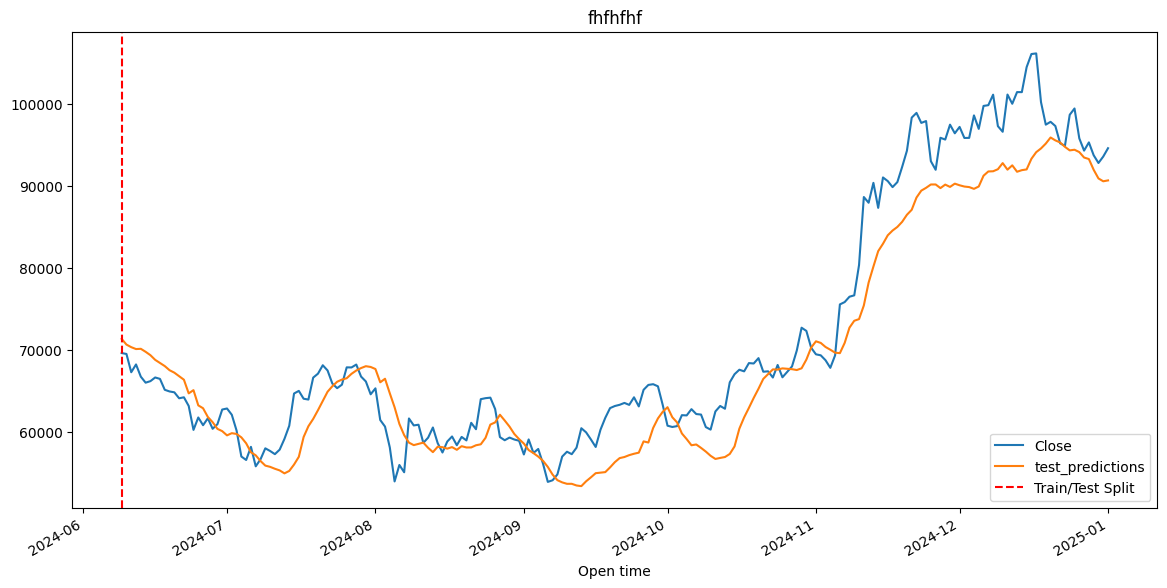

In [13]:
df["test_predictions"] = np.nan
df.loc[df.index[-len(y_pred_inv):], "test_predictions"] = y_pred_inv
df[["Close", "test_predictions"]].iloc[-len(y_pred_inv):].plot(figsize=(14, 7), title="fhfhfhf")

plt.axvline(x=df.index[-len(y_pred_inv)], color='red', linestyle='--', label='Train/Test Split')
plt.legend()

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


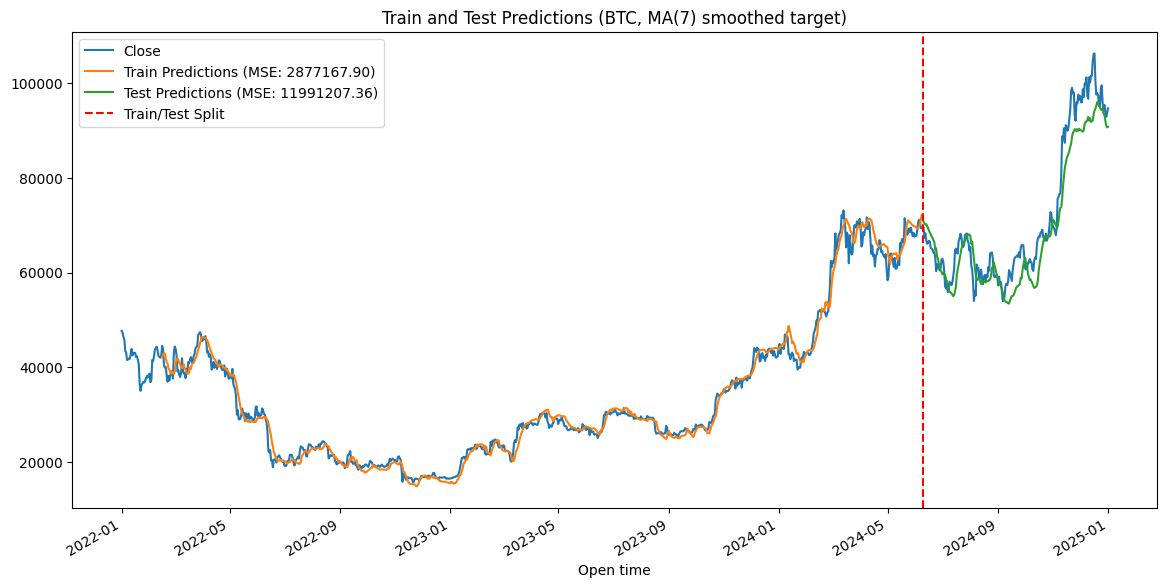

In [15]:
# Generate predictions for the training set
train_X = best_data_scaled[:-len(best_y_val)]
train_y = best_df_all[TARGET].iloc[:-len(best_y_val)].values

# Build sequences for training predictions
train_sequences = [
    train_X[i-sequence_length:i]
    for i in range(sequence_length, len(train_X))
]
train_sequences = np.array(train_sequences)

# Predict on the training set
train_y_pred = best_model.predict(train_sequences).flatten()

# Create a placeholder array with zeros, except for the last column (target)
dummy_train = np.zeros((len(train_y_pred), train_sequences.shape[2]))
dummy_train[:, -1] = train_y_pred

# Inverse transform using the entire dummy array
train_y_pred_inv = best_scaler.inverse_transform(dummy_train)[:, -1]

# Add train predictions to the dataframe
df["train_predictions"] = np.nan
df.loc[df.index[sequence_length:len(train_y_pred) + sequence_length], "train_predictions"] = train_y_pred_inv

# Plot the entire timeframe with train and test predictions
df[["Close", "train_predictions", "test_predictions"]].plot(figsize=(14, 7), title="Train and Test Predictions (BTC, MA(7) smoothed target)")

plt.axvline(x=df.index[-len(y_pred_inv)], color='red', linestyle='--', label='Train/Test Split')
plt.legend()
# Calculate MSE for train and test predictions
mse_train = mean_squared_error(df.loc[df.index[sequence_length:len(train_y_pred) + sequence_length], "Close"], train_y_pred_inv)
mse_test = mean_squared_error(val_predictions["Actual"], val_predictions["Predicted"])

# Update legend with MSE values
plt.legend([
    f"Close",
    f"Train Predictions (MSE: {mse_train:.2f})",
    f"Test Predictions (MSE: {mse_test:.2f})",
    f"Train/Test Split"
])

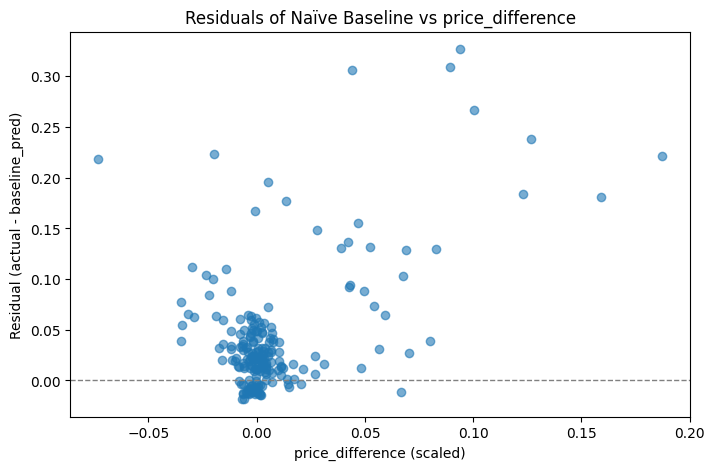

NameError: name 'np' is not defined

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats



# 3) Compute residuals relative to baseline
# residuals_baseline = preds - baseline_preds
residuals_baseline = y_val_inv - y_pred_inv

# 4) Extract the same feature (e.g. 'RSI') for X-axis
feature_to_plot = 'price_difference'  # or 'RSI', etc.

X_feat = y_val_inv - pd.Series(y_val_inv).shift(1)


# 5) Plot residuals of the benchmark vs. feature
plt.figure(figsize=(8,5))
plt.scatter(X_feat, residuals_baseline, alpha=0.6)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel(f'{feature_to_plot} (scaled)')
plt.ylabel('Residual (actual - baseline_pred)')
plt.title(f'Residuals of Naïve Baseline vs {feature_to_plot}')
plt.show()


# fig, (ax_scatter, ax_hist) = plt.subplots(2, 1, figsize=(8, 10))

# # Scatter: baseline residuals vs feature
# ax_scatter.scatter(X_feat, residuals_baseline, alpha=0.6)
# ax_scatter.axhline(0, color='gray', linestyle='--', linewidth=1)
# ax_scatter.set_xlabel(f'{feature_to_plot} (scaled)')
# ax_scatter.set_ylabel('Residual (actual - baseline_pred)')
# ax_scatter.set_title(f'Residuals of Naïve Baseline vs {feature_to_plot}')

data = pd.DataFrame({'X': residuals_baseline, 'Y': X_feat})
data.dropna(inplace=True)


# bins = np.quantile(data['Y'], np.linspace(0, 1, 11))
# cond_vals = []
# for i in range(len(bins)-1):
#     mask = (data['Y'] >= bins[i]) & (data['Y'] < bins[i+1])
#     x_bin = data.loc[mask, 'X']
#     if len(x_bin) > 1:
#         x_std = (x_bin - x_bin.mean()) / x_bin.std(ddof=0)
#         cond_vals.append(x_std)
# cond_X = pd.concat(cond_vals, ignore_index=True)

# ax_hist.hist(cond_X, bins=30, density=True, alpha=0.7)
# ax_hist.set_xlabel(f'{feature_to_plot} (standardized within Y-bins)')
# ax_hist.set_ylabel('Density')
# ax_hist.set_title('Distribution of Detrended Conditional Feature')

# plt.tight_layout()
# plt.show()

bins = np.quantile(data['Y'], np.linspace(0, 1, 11))
bins = np.quantile(data['Y'], np.linspace(0, 1, 6))

# Prepare a grid for plotting
x_min, x_max = data['X'].min(), data['X'].max()
x_grid = np.linspace(x_min, x_max, 200)

# Choose a colormap and number of bins
cmap = plt.get_cmap("viridis")
n_bins = len(bins) - 1
z_grid = np.linspace(-3, 3, 200)   # covers ±3σ

plt.figure(figsize=(8,5))
for i in range(n_bins):
    mask = (data['Y'] >= bins[i]) & (data['Y'] < bins[i+1])
    x_bin = data.loc[mask, 'X']
    if len(x_bin) > 1:
        # Standardize within bin
        mean_i = x_bin.mean()
        std_i  = x_bin.std(ddof=0)
        x_std = (x_bin - mean_i) / std_i
        
        # Fit KDE on standardized data
        kde = stats.gaussian_kde(x_std)
        
        # Evaluate KDE on grid (standardize grid same as x_bin)
        x_std_grid = (x_grid - mean_i) / std_i
        y_kde = kde(x_std_grid)

        
        z = (x_bin - x_bin.mean()) / x_bin.std(ddof=0)
        # fit KDE
        kde = stats.gaussian_kde(z)
        # evaluate on the z-grid
        y_kde = kde(z_grid)
        
        # Compute color and line width as gradient
        frac = i / (n_bins - 1)
        color = cmap(frac)
        # linewidth = 0.5 + 2.5 * frac
        linewidth = 2

        if len(x_bin) < 30:
            alpha = 0.5
            linewidth = 0.5
        else:
            alpha = 1
        
        plt.plot(
            x_grid, kde(x_std_grid),
            color=color,
            linewidth=linewidth,
            label=f'Bin {i+1}',
            alpha=alpha
        )
        plt.xlabel(f'{feature_to_plot} (original scale)')
        plt.ylabel('Density')

        # plt.plot(
        #     z_grid, kde(z_grid),
        #     color=cmap(frac),
        #     linewidth=0.5 + 2.5*frac,
        #     label=f'Bin {i+1}'
        # )
        # plt.xlabel(f'z-score of {feature_to_plot}')
        # plt.ylabel('Density')

plt.title('Conditional KDE of residual by feature Decile')
plt.legend()
# Optional: only show legend if desired
# plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [11]:
# Save the trained model
best_model.save(SAVE_MODEL)

# Save the scaler
joblib.dump(best_scaler, SAVE_SCALER)

# Save the dataframe
best_df_all.to_csv(SAVE_DF)

# Save validation predictions with date index
val_predictions = pd.DataFrame({
    "Date": df.index[-len(best_y_val):],
    "Actual": y_val_inv,
    "Predicted": y_pred_inv
})
val_predictions.set_index("Date", inplace=True)
val_predictions.to_csv(SAVE_PREDICTIONS)

In [27]:
from IPython import get_ipython

ipy = get_ipython()
for var in ipy.user_ns:
    if not var.startswith('_'):  # Skip private/internal variables
        try:
            ipy.run_line_magic('store', var)
        except Exception as e:
            print(f"Could not store variable {var}: {e}")

Stored 'In' (list)
Could not store variable Out: cannot pickle 'module' object
Stored 'get_ipython' (function)
Could not store variable exit: Can't pickle local object 'ScriptMagics._make_script_magic.<locals>.named_script_magic'
Could not store variable quit: Can't pickle local object 'ScriptMagics._make_script_magic.<locals>.named_script_magic'
Could not store variable open: Can't pickle <function open at 0x00000224058E2E80>: it's not the same object as io.open
Stored 'ASSET' (str)
Stored 'TARGET' (str)
Stored 'SAVE_DF' (str)
Stored 'SAVE_SCALER' (str)
Stored 'SAVE_MODEL' (str)
Stored 'SAVE_PREDICTIONS' (str)
Could not store variable optuna: cannot pickle 'module' object
Stored 'Adam' (type)
Stored 'RMSprop' (type)
Stored 'Sequential' (type)
Stored 'LSTM' (type)
Stored 'Dense' (type)
Stored 'train_test_split' (function)
Stored 'mean_squared_error' (function)
Could not store variable plt: cannot pickle 'module' object
Could not store variable pd: cannot pickle 'module' object
Could no